<a href="https://colab.research.google.com/github/Xodarap/notebooks/blob/main/ycombinator%20valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
import io

df=pd.read_csv(io.StringIO(uploaded['yc_new.csv'].decode('ISO-8859-1')))
df

Saving yc_new.csv to yc_new.csv


,Company,Valuation,Batch year,Valuation year,Source,implied value per year,Rank
0,Stripe,"$74,000,000,000.00",2009,2022.0,https://techcrunch.com/2022/07/20/stripes-new-...,"$5,285,714,285.71",#REF!
1,Instacart,"$24,000,000,000.00",2012,2022.0,https://www.cnbc.com/2022/03/25/instacart-slas...,"$2,181,818,181.82",NaN
2,Cruise automation,"$18,000,000,000.00",2014,2020.0,https://www.abiresearch.com/market-research/pr...,"$2,000,000,000.00",#REF!
3,OpenSea,"$13,000,000,000.00",2018,2022.0,https://techcrunch.com/2022/01/05/making-sense...,"$2,600,000,000.00",#REF!
4,Faire,"$12,400,000,000.00",2017,2021.0,https://news.faire.com/2021/11/16/announcing-4...,"$2,066,666,666.67",#REF!
...,...,...,...,...,...,...,...
323,NYSE: PD,"$2,328,574,922.00",2010,NaN,NaN,NaN,NaN
324,NASDAQ:PRDS,"$89,742,128.00",2020,NaN,NaN,NaN,NaN
325,NASDAQ:PRST,"$109,381,993.00",2010,NaN,NaN,NaN,NaN
326,NASDAQ:RGTI,"$83,342,182.00",2014,NaN,NaN,NaN,NaN


In [2]:
df['Valuation year'] = df['Valuation year'].fillna(2022)
df['Valuation'] = pd.to_numeric(df['Valuation'].str.replace('[^-.0-9]', ''))
df['implied value per year'] = df['Valuation'] / (df['Valuation year'] - df['Batch year'])
df.loc[df['Valuation year'] == df['Batch year'], 'implied value per year'] = df['Valuation']

<ipython-input-2-a9d77c322a78>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Valuation'] = pd.to_numeric(df['Valuation'].str.replace('[^-.0-9]', ''))


In [3]:

number_of_companies = 3951
co_per_percentile = int(number_of_companies / 100)

In [4]:
import math
import numpy as np
sorted = [v for v in df['implied value per year'] if not math.isnan(v)]
sorted.sort(reverse = True)
adj_count = int((len(sorted) / len(df['implied value per year'])) * co_per_percentile)
percentiles = {(100-idx): sorted[adj_count * idx - 1] for idx in range(1, 9)}
percentiles[99.9] = sorted[2]
df[np.isinf(df['implied value per year'])]

,Company,Valuation,Batch year,Valuation year,Source,implied value per year,Rank


In [5]:
from scipy.optimize import curve_fit
import scipy.stats as ss
from scipy.stats import pareto
from scipy.stats import powerlaw
from scipy.optimize import minimize
import numpy as np
fitted = []
failed = []
dist_list = [['pareto', [.8, 10000, 1000000]],
             ['lognorm', [10, 10, 10]],
             ['powerlaw', [0.01, 10000000, 100000000000]],
             ['norm', [1000, 1e9]]]
data_out = [float(k)/100 for k in percentiles.keys()]
data_in = [v for v in percentiles.values()]

for d in dist_list:

    dist_name = d[0] #fetch the distribution name
    dist_object = getattr(ss, dist_name)  #fetch the distribution object
    param_default = d[1] #fetch the default distribution parameters

    # For distributions with only location and scale set those to the default loc=0 and scale=1
    if not param_default:
        param_default = (0,1)
    
    # Computed parameters of fitted distribution
    try:
        param,cov = curve_fit(dist_object.cdf,data_in,data_out,p0=param_default,method='trf')

        # Only take distributions which do not result in zero covariance as those are not a valid fit
        if np.any(cov):
            fitted.append((dist_name,param),)

    # Capture which distributions are not possible to be fitted (variety of reasons)       
    except (NotImplementedError,RuntimeError) as e:
        failed.append((dist_name,e),)
        pass

fitted
# failed

[('pareto', array([ 1.32736698e+00, -1.42620204e+08,  2.32579656e+07])),
 ('lognorm', array([ 2.04456976e+00, -9.09437739e+07,  5.90098737e+06])),
 ('powerlaw', array([ 2.21408511e-02, -6.17393285e+06,  8.58096479e+08])),
 ('norm', array([1.e+03, 1.e+09]))]

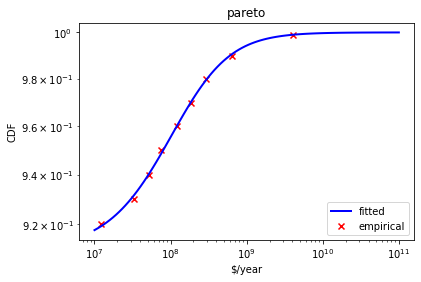

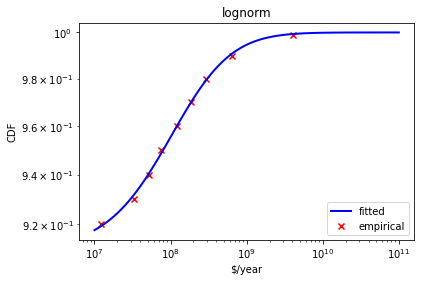

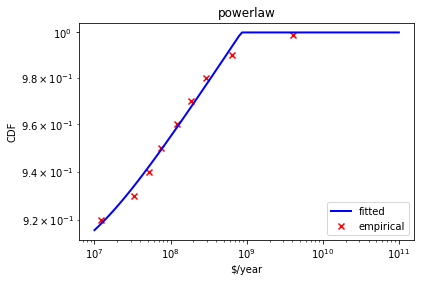

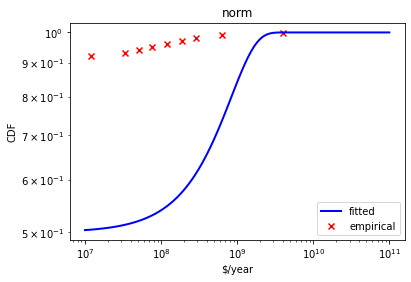

In [6]:
from matplotlib import pyplot
for f in fitted:
  pyplot.subplot(1, 1, 1)
  params = f[1]
  dist_object = getattr(ss, f[0])
  # Powers of 10
  x = np.linspace(7,11, 100)
  a = [10**i for i in x]
  # Plotting the graph
  pyplot.plot(a, dist_object.cdf(a , *params), color='blue', lw=2)
  pyplot.scatter(percentiles.values(), [float(k)/100 for k in percentiles.keys()],
                color = 'red', marker = 'x')

  # Setting a logarithmic scale for y-axis
  pyplot.yscale('log')
  pyplot.xscale('log')
  pyplot.title(f[0])
  pyplot.ylabel('CDF')
  pyplot.xlabel('$/year')
  pyplot.legend(['fitted', 'empirical'], loc='lower right')
  pyplot.show()

In [7]:
for f in fitted:
  params = f[1]
  dist_object = getattr(ss, f[0])
  print(f[0], dist_object.mean(*params), params)

pareto -48316692.93417607 [ 1.32736698e+00 -1.42620204e+08  2.32579656e+07]
lognorm -43228457.44366244 [ 2.04456976e+00 -9.09437739e+07  5.90098737e+06]
powerlaw 12413511.690680629 [ 2.21408511e-02 -6.17393285e+06  8.58096479e+08]
norm 1000.0 [1.e+03 1.e+09]


In [43]:
yc_companies = 3951
yc_cos_after_2019 = 1825
avg_team = 2.285714286
avg_ownership = 0.35

In [44]:
df['years elapsed'] = df['Valuation year'] - df['Batch year']
df.loc[df['years elapsed'] == 0, 'years elapsed'] = 1
df['0% discount'] = df['Valuation'] / df['years elapsed']
df['12% discount'] = (.88 ** df['years elapsed']) * df['Valuation'] / df['years elapsed']
df['20% discount'] = (.8 ** df['years elapsed']) * df['Valuation'] / df['years elapsed']

In [45]:
from math import log, floor

def human_format(number):
    units = ['', 'K', 'M', 'B', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    return '$%.2f%s/y' % (number / k**magnitude, units[magnitude])

results = pd.DataFrame(
    [[k, human_format(avg_ownership * df[k].sum() / yc_companies / avg_team), 
      human_format(avg_ownership * df[k].sum() / yc_cos_after_2019 / avg_team)] 
      for k in ['0% discount', '12% discount', '20% discount']],
      columns = ['Discount', 'All companies', 'Excluding post-2019'])
results

,Discount,All companies,Excluding post-2019
0,0% discount,$3.77M/y,$8.17M/y
1,12% discount,$1.98M/y,$4.28M/y
2,20% discount,$1.34M/y,$2.90M/y


In [46]:
powerlaw_params = [f[1] for f in fitted if f[0] == 'powerlaw'][0]
powerlaw_results = pd.DataFrame(
    [[k, human_format(powerlaw.mean(*powerlaw_params) / yc_companies / avg_team), 
      human_format(df[k].sum() / yc_cos_after_2019 / avg_team)] 
      for k in ['0% discount', '12% discount', '20% discount']],
      columns = ['Discount', 'All companies', 'Excluding post-2019'])
powerlaw_results

,Discount,All companies,Excluding post-2019
0,0% discount,$1.37K/y,$23.34M/y
1,12% discount,$1.37K/y,$12.24M/y
2,20% discount,$1.37K/y,$8.29M/y


In [47]:
has_data = df[df['0% discount'] > 0 & ~np.isnan(df['years elapsed'])]
total_years = (yc_companies - len(has_data)) * has_data['years elapsed'].mean() + has_data['years elapsed'].sum()
total_years_no_2019 = (yc_cos_after_2019 - len(has_data)) * has_data['years elapsed'].mean() + has_data['years elapsed'].sum()
results = pd.DataFrame(
    [[k, human_format(avg_ownership * (has_data['years elapsed'] * has_data[k]).sum() / avg_team / total_years), 
      human_format(avg_ownership * (has_data['years elapsed'] * has_data[k]).sum() / total_years_no_2019 / avg_team)] 
      for k in ['0% discount', '12% discount', '20% discount']],
      columns = ['Discount', 'All companies', 'Excluding post-2019'])
results

,Discount,All companies,Excluding post-2019
0,0% discount,$4.56M/y,$9.87M/y
1,12% discount,$1.84M/y,$3.98M/y
2,20% discount,$1.06M/y,$2.30M/y


In [65]:
def format_ny(x):
  return human_format(x)[0:-2]
comp = pd.DataFrame([
    ['Total Value', '', format_ny(df['Valuation'].sum()), '', format_ny(26e9)],
    ['Per Company', yc_companies, format_ny(df['Valuation'].sum() / yc_companies), '', '(unpublished)'],
    ['Per founding team', 1/avg_ownership, format_ny(avg_ownership * df['Valuation'].sum() / yc_companies), 1/0.35, format_ny(48e6)],
    ['Per Founder', avg_team, format_ny(avg_ownership * df['Valuation'].sum() / yc_companies  / avg_team), 39/18, format_ny(18e6)],
    ['Per Year', df['years elapsed'].mean(), human_format(avg_ownership * df['Valuation'].sum() / yc_companies / avg_team / df['years elapsed'].mean()), 7, human_format(25e5)],
], columns = ['Step', 'My Factor', 'My Analysis', 'Ryan\'s Factor', 'Ryan\'s Analysis'])
pd.options.display.float_format = '{:.2f}'.format
comp

,Step,My Factor,My Analysis,Ryan's Factor,Ryan's Analysis
0,Total Value,,$561.50B,,$26.00B
1,Per Company,3951,$142.12M,,(unpublished)
2,Per founding team,2.86,$49.74M,2.86,$48.00M
3,Per Founder,2.29,$21.76M,2.17,$18.00M
4,Per Year,4.66,$4.67M/y,7,$2.50M/y
